# RN Text Classification

---
## Data Check

- NSMC 데이터
    - Naver sentiment movie corpus v1.0
    - 네이버 영화 댓글 감정분석 데이터셋
    - 이진 분류
- https://github.com/e9t/nsmc

In [59]:
import pandas as pd

df = pd.read_csv('data/ratings_train.txt', sep='\t')
df.head(2)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1


In [60]:
df['label'].value_counts()

label
0    75173
1    74827
Name: count, dtype: int64

In [61]:
df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [62]:
df = df.dropna(how='any', axis=0)
df.shape

(149995, 3)

---
## Tokenization

In [63]:
vocab = set()
for doc in df['document']:
    for token in doc.split():
        vocab.add(token)

In [64]:
len(vocab)

357862

In [65]:
vocab_cnt_dict = {}
for doc in df['document']:
    for token in doc.split():
        if token not in vocab_cnt_dict:
            vocab_cnt_dict[token] = 0
        vocab_cnt_dict[token] += 1

In [66]:
vocab_cnt_list = [(token, cnt) for token, cnt in vocab_cnt_dict.items()]

In [67]:
vocab_cnt_list[:10]

[('아', 1204),
 ('더빙..', 2),
 ('진짜', 5929),
 ('짜증나네요', 10),
 ('목소리', 99),
 ('흠...포스터보고', 1),
 ('초딩영화줄....오버연기조차', 1),
 ('가볍지', 17),
 ('않구나', 2),
 ('너무재밓었다그래서보는것을추천한다', 1)]

In [68]:
top_vocabs = sorted(vocab_cnt_list, key= lambda tup: tup[1], reverse=True)

In [69]:
import matplotlib.pyplot as plt
import numpy as np

In [70]:
cnts = [cnt for _, cnt in top_vocabs]

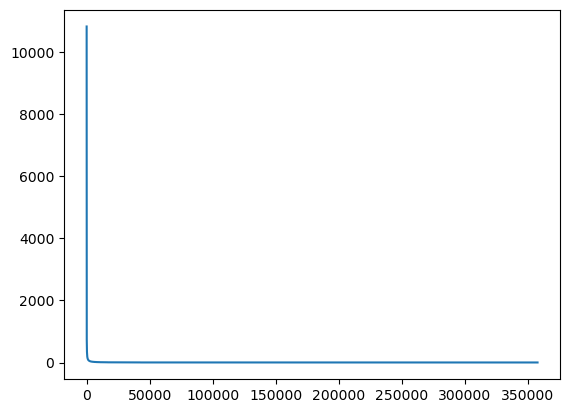

In [71]:
plt.plot(range(len(cnts)), cnts)

In [72]:
np.mean(cnts)

3.1792590439890236

In [73]:
cnts[:10]

[10825, 8239, 7791, 5929, 5059, 3598, 3285, 3260, 3249, 3237]

In [74]:
sum(np.array(cnts)>=3)

42635

In [75]:
n_vocab = sum(np.array(cnts)>=3)
top_vocabs = top_vocabs[:n_vocab]

In [76]:
vocabs = [token for token, _ in top_vocabs]
vocabs[:5]

['영화', '너무', '정말', '진짜', '이']

---
## UNK, PAD Token

In [77]:
vocabs.insert(0, '[UNK]')

In [78]:
vocabs.insert(0, '[PAD]')

In [79]:
idx_to_token = vocabs
token_to_idx = {token:i for i, token in enumerate(idx_to_token)}

In [80]:
class Tokenizer:
    
    def __init__(self, vocabs, use_padding=True, max_padding=64, pad_token='[PAD]', unk_token='[UNK]'):
        self.idx_to_token = vocabs
        self.token_to_idx = {token: i for i, token in enumerate(self.idx_to_token)}
        
        self.use_padding = use_padding
        self.max_padding = max_padding
        
        self.pad_token = pad_token
        self.unk_token = unk_token
        
        self.unk_token_idx = self.token_to_idx[self.unk_token]
        self.pad_token_idx = self.token_to_idx[self.pad_token]
        
    def __call__(self, x:str):
        token_ids = []
        token_list = x.split()
        
        for token in token_list:
            if token in self.token_to_idx:
                token_idx = self.token_to_idx[token]
            else:
                token_idx = self.unk_token_idx
            token_ids.append(token_idx)
        
        if self.use_padding:
            token_ids = token_ids[:self.max_padding]
            n_pads = self.max_padding - len(token_ids)
            token_ids = token_ids + [self.pad_token_idx] * n_pads
        
        return token_ids

In [81]:
tokenizer = Tokenizer(vocabs, use_padding=False)

In [82]:
sample = df['document'].iloc[0]
print(sample)

아 더빙.. 진짜 짜증나네요 목소리


In [83]:
tokenizer(sample)

[51, 1, 5, 10485, 1064]

In [84]:
token_length_list = []
for sample in df['document']:
    token_length_list.append(len(tokenizer(sample)))

Text(0, 0.5, 'cnt')

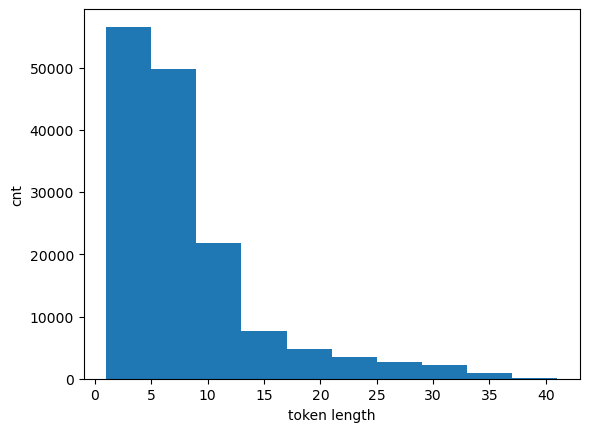

In [85]:
plt.hist(token_length_list)
plt.xlabel('token length')
plt.ylabel('cnt')

In [86]:
max(token_length_list)

41

In [87]:
tokenizer = Tokenizer(
    vocabs,
    use_padding=True,
    max_padding=50,
    pad_token='[PAD]',
    unk_token='[UNK]'
)

In [88]:
len(tokenizer(sample)), tokenizer(sample)[:10]

(50, [201, 2, 3635, 1, 121, 1946, 2, 0, 0, 0])

---
## DataLoader

In [89]:
import torch
from torch.utils.data import Dataset, DataLoader

In [90]:
train_valid_df = pd.read_csv('data/ratings_train.txt', sep='\t')
test_df = pd.read_csv('data/ratings_test.txt', sep='\t')

In [91]:
len(train_valid_df), len(test_df)

(150000, 50000)

In [92]:
train_valid_df = train_valid_df.sample(frac=1.)

In [93]:
train_ratio = 0.8
n_train = int(len(train_valid_df) * train_ratio)

train_df = train_valid_df[:n_train]
valid_df = train_valid_df[n_train:]

In [94]:
len(train_df), len(valid_df), len(test_df)

(120000, 30000, 50000)

In [95]:
# 1/10 샘플링
train_df = train_df.sample(frac=0.1)
valid_df = valid_df.sample(frac=0.1)
test_df = test_df.sample(frac=0.1)

In [96]:
class NSMCDataset(Dataset):
    
    def __init__(self, data_df, tokenizer=None):
        self.data_df = data_df
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        sample_raw = self.data_df.iloc[idx]
        sample = {}
        
        sample['doc'] = str(sample_raw['document'])
        sample['label'] = int(sample_raw['label'])
        
        assert sample['label'] in set([0, 1])
        
        if self.tokenizer is not None:
            sample['doc_ids'] = self.tokenizer(sample['doc'])
        
        return sample

In [97]:
def collate_fn(batch):
    keys = [key for key in batch[0].keys()]
    data = {key: [] for key in keys}
    
    for item in batch:
        for key in keys:
            data[key].append(item[key])
    
    return data

In [98]:
train_dataset = NSMCDataset(
    data_df=train_df,
    tokenizer=tokenizer
)
valid_dataset = NSMCDataset(
    data_df=valid_df,
    tokenizer=tokenizer
)
test_dataset = NSMCDataset(
    data_df=test_df,
    tokenizer=tokenizer
)

train_dataloader = DataLoader(train_dataset,
                              batch_size=128,
                              collate_fn=collate_fn,
                              shuffle=True)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=128,
                              collate_fn=collate_fn,
                              shuffle=False)
test_dataloader = DataLoader(test_dataset,
                             batch_size=128,
                             collate_fn=collate_fn,
                             shuffle=False)

In [99]:
sample = next(iter(test_dataloader))

In [100]:
sample.keys()

dict_keys(['doc', 'label', 'doc_ids'])

In [101]:
sample['doc'][2]

'워쇼스키들의 역량은 매트릭스에서 완전히. 단 1g도 안남기고 철저히 고갈되었음을 스스로 증명해 보인 영화.'

In [102]:
sample['doc_ids'][2][:10]

[1, 1, 1, 1, 936, 1, 1, 4761, 1, 1235]